In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier

import xgboost as xgb
import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

## Read data

In [2]:
df = pd.read_csv('C:/Temp/all_real_quad_fields.csv')

Columns are:
 * 'defining_polynomial'
 * 'class_number'
 * 'discriminant'
 * 'res_s=0'
 * 'number_roots_unity'
 * 'regulator'
 * 'a_1', 'a_2', 'a_3', ..., 'a_1000'

In [3]:
#print(df.columns.tolist())
#print(df.iloc[0:3, np.r_[0,1,2,3,4,5,6,7,8,9,10,11:13]])
print(df.iloc[0:3, np.r_[0,1,2,6,1005]])

  defining_polynomial  class_number  discriminant  a_1  a_1000
0         x^2 - x - 1             1           5.0    1       0
1             x^2 - 2             1           8.0    1       0
2             x^2 - 3             1          12.0    1       0


In [12]:
value_cnts = df.class_number.value_counts()
print(value_cnts[:8])

df_value_cnts = value_cnts.to_frame()
#print(df_value_cnts.iloc[0:8,:])
df_value_cnts.to_csv('C:/Temp/value_counts.csv', index=True)


2     183432
1     177159
4     120440
8      45756
6      25395
3      25201
12     16495
16     13583
Name: class_number, dtype: int64


In [5]:
#df_all = df[df.class_number <= 2]
df_all = df

In [6]:
NEW_CLASS_NAME_ONE = 0
NEW_CLASS_NAME_TWO = 1
NEW_CLASS_NAME_THREE = 2
NEW_CLASS_NAME_FOUR = 3
NEW_CLASS_NAME_FIVE = 4
df_all.class_number.replace(1, NEW_CLASS_NAME_ONE, inplace=True)
df_all.class_number.replace(2, NEW_CLASS_NAME_TWO, inplace=True)
df_all.class_number.replace(3, NEW_CLASS_NAME_THREE, inplace=True)
df_all.class_number.replace(4, NEW_CLASS_NAME_FOUR, inplace=True)
df_all.loc[df_all.class_number > 4, 'class_number'] = NEW_CLASS_NAME_FIVE

In [7]:
print(df.class_number.value_counts()[:8])

1    183432
4    178903
0    177159
3    120440
2     25201
Name: class_number, dtype: int64


In [131]:
# For logistic regression we reduce the data set to class_number<2
df_all = df_all[df_all.class_number <= 1]
print(df_all.class_number.value_counts()[:8])

1    183432
0    177159
Name: class_number, dtype: int64


### Split data in train and test

In [11]:
# column 1 contains class values
predict_col = 1
df_train, df_test = train_test_split(df_all, test_size=0.3, stratify=df_all.iloc[:, predict_col])

#predict_col = 11
#df_train, df_test = train_test_split(df_all, test_size=0.9, stratify=df_all.iloc[:, predict_col])

## Achtung

X_test und y_test werden mehrfach verwendet, sind also keine echten Testdaten sondern Validierungsdaten

X_train, X_test => Features <br>
y_train, y_test => Klassen / Labels <br>

In [128]:
#col_train = np.r_[2,3,4,5,6:1007]
col_train = np.r_[6:1006]

#most important features: zeta_320, zeta_80, zeta_250, zeta_720, zeta_810, zeta_800, zeta_640, zeta_750
#col_train = np.r_[324,254,725,805,645,755]
#col_train = np.r_[15,35,105,10,11,905,226]

# column to predict is 'class_number' (1st column)
# column indexing is zero-based
y_train = df_train.iloc[:, predict_col]
y_test = df_test.iloc[:, predict_col]

# matrix of explanatory variables includes
X_train = df_train.iloc[:, col_train]
X_test = df_test.iloc[:, col_train]

## Training

### Logistic Regression

In [17]:
LR = LogisticRegression(random_state=0, solver='lbfgs').fit(X_train, y_train)
print(LR.score(X_test, y_test))

C:\Development\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.7095157980365694


### Support Vector Machine / Regression

In [12]:
df_reduced = df_all.sample(100)
# column 3 contains class values
df_train_reduced, df_test_reduced = train_test_split(df_reduced, test_size=0.2, stratify=df_reduced.iloc[:, 2])
col_train = np.r_[1,2,7,8,9,10,11:15]

# column to predict is 'class_number' (3rd column)
# column indexing is zero-based
y_train_reduced = df_train_reduced.iloc[:,2]
y_test_reduced = df_test_reduced.iloc[:,2]

# matrix of explanatory variables includes
X_train_reduced = df_train_reduced.iloc[:, col_train]
X_test_reduced = df_test_reduced.iloc[:, col_train]

svc_lin = svm.LinearSVC()
svc_nu = svm.NuSVC(gamma='auto')
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1, cache_size=300)
svr_poly.fit(X_train_reduced, y_train_reduced)

score = svr_poly.score(X_test_reduced, y_test_reduced)
print(score)

### Random Forest Classifier

In [109]:
RF = RandomForestClassifier(n_estimators=10, random_state=0).fit(X_train, y_train)
print(RF.score(X_test, y_test))

#analyze the importance of zeta coefficients
#feature_names = [f'zeta {i}' for i in range(1,1001)]
#feature_importances = pd.Series(RF.feature_importances_, index=feature_names).sort_values(ascending=False)
#print(feature_importances[:8])

0.6772356671411932


### Decision Tree Classifier

In [22]:
DT = DecisionTreeClassifier().fit(X_train, y_train)
print(DT.score(X_test, y_test))

0.6620384921148478


### MLP  (neural network)

In [23]:
MLP = MLPClassifier(hidden_layer_sizes=4, activation="relu", solver="adam", alpha=0.0001, learning_rate="adaptive", max_iter=100).fit(X_train, y_train)
print(MLP.score(X_test, y_test))

C:\Development\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.



0.7566233430087449


In [133]:
XGB = xgb.XGBClassifier(use_label_encoder=False, n_estimators=100, max_depth=8, learning_rate=0.1, subsample=0.5,
                        eval_metric="logloss").fit(X_train, y_train)
print(XGB.score(X_test, y_test))


0.8391724749949158


In [134]:
#analyze the importance of zeta coefficients
feature_names = [f'zeta {i}' for i in range(1,1001)]
feature_importances = pd.Series(XGB.feature_importances_, index=feature_names).sort_values(ascending=False)
print(feature_importances[:30])

zeta 180    0.075248
zeta 10     0.027164
zeta 30     0.021521
zeta 100    0.015332
zeta 5      0.014347
zeta 6      0.013723
zeta 900    0.013254
zeta 221    0.011839
zeta 477    0.011622
zeta 13     0.008363
zeta 637    0.008097
zeta 377    0.007758
zeta 244    0.007570
zeta 549    0.007328
zeta 116    0.007081
zeta 36     0.006564
zeta 468    0.006214
zeta 697    0.006122
zeta 493    0.006047
zeta 15     0.005789
zeta 629    0.005666
zeta 533    0.005562
zeta 164    0.005480
zeta 452    0.005361
zeta 35     0.005284
zeta 17     0.005244
zeta 833    0.005225
zeta 292    0.005222
zeta 65     0.005208
zeta 981    0.005041
dtype: float32


### Ada Boost Classifier

In [25]:
ADBoost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10).fit(X_train, y_train)
print(ADBoost.score(X_test, y_test))

0.6619645399249385


## Visualization

In [8]:
df_plot = df_all.sample(4000)

dr1 = go.Scatter3d(
    x=df_plot[df_plot['class_number'] == NEW_CLASS_NAME_ONE]['res_s=0'],
    y=df_plot[df_plot['class_number'] == NEW_CLASS_NAME_ONE]['regulator'],
    z=df_plot[df_plot['class_number'] == NEW_CLASS_NAME_ONE]['discriminant'],
    mode='markers',
    marker = dict(size=3,
                  color='rgb(255,0,0)',
                  line=dict(width=1)),
    name ='class_number_1'
)
dr2 = go.Scatter3d(
    x=df_plot[df_plot['class_number'] == NEW_CLASS_NAME_TWO]['res_s=0'],
    y=df_plot[df_plot['class_number'] == NEW_CLASS_NAME_TWO]['regulator'],
    z=df_plot[df_plot['class_number'] == NEW_CLASS_NAME_TWO]['discriminant'],
    mode='markers',
    marker = dict(size=3,
                  color='rgb(0,255,0)',
                  line=dict(width=1)),
    name ='class_number_2'
)
dr3 = go.Scatter3d(
    x=df_plot[df_plot['class_number'] == NEW_CLASS_NAME_THREE]['res_s=0'],
    y=df_plot[df_plot['class_number'] == NEW_CLASS_NAME_THREE]['regulator'],
    z=df_plot[df_plot['class_number'] == NEW_CLASS_NAME_THREE]['discriminant'],
    mode='markers',
    marker = dict(size=3,
                  color='rgb(0,0,255)',
                  line=dict(width=1)),
    name ='class_number_3'
)
dr4 = go.Scatter3d(
    x=df_plot[df_plot['class_number'] == NEW_CLASS_NAME_FOUR]['res_s=0'],
    y=df_plot[df_plot['class_number'] == NEW_CLASS_NAME_FOUR]['regulator'],
    z=df_plot[df_plot['class_number'] == NEW_CLASS_NAME_FOUR]['discriminant'],
    mode='markers',
    marker = dict(size=3,
                  color='rgb(0,0,0)',
                  line=dict(width=1)),
    name ='class_number_4'
)
data = [dr1, dr2, dr3, dr4]
layout = go.Layout(
    title='class_number',
    scene = dict(
        xaxis = dict(title='regulator'),
        yaxis = dict(title='discriminant'),
        zaxis = dict(title='residue at s=0'),)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='class_number')
fig.write_html("C:/Temp/class_number.html")

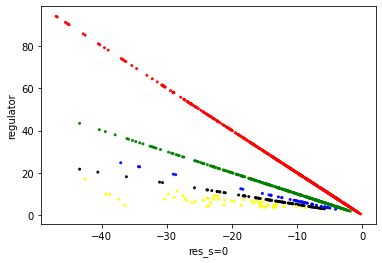

In [9]:
df_plot = df_all[df_all.class_number <= 4]
df_plot = df_plot.iloc[0:1000]
# df_plot = df_all
x = df_plot['res_s=0'].to_numpy()
y = df_plot['regulator'].to_numpy()
colors = df_all['class_number']
color_map = {0:'red', 1:'green', 2:'blue', 3:'black', 4:'yellow'}

f = plt.figure()
plt.scatter(x, y, s=4, alpha=0.9, c=df_plot.class_number.map(color_map))
# plt.title("class 1 (red) and class 2 (blue) for x^2 + bx + c")
plt.xlabel("res_s=0")
plt.ylabel("regulator")
plt.savefig('C:/Temp/class_number.pdf')  
plt.show()